In [1]:
# Vector data
import geopandas as gpd

# Tabular data 
import pandas as pd
import numpy as np

# Raster array
import xarray as xr
import rioxarray as rio
from rasterio.enums import Resampling

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# System
from pathlib import Path
import os
import copy

# Output directory

In [2]:
# Specify the desired output folder path for processed dataset
output_data_dir = Path.cwd() / ".." / "output_data"

# Check if the output folder exists, and create if not
Path.mkdir(output_data_dir, exist_ok=True, parents=True)

In [3]:
# Specify the desired output folder path for figures
output_figure_dir = Path.cwd() / ".." / "output_figures"

# Check if the output folder exists, and create if not
Path.mkdir(output_figure_dir, exist_ok=True, parents=True)

# Input data

In [4]:
input_dir = Path.cwd() / ".." / "forest_data" / "raw_data"

### Subregion borders
CRS: EPSG:4326

In [5]:
# import subregion borders in gpd format, make sure the directory is correct
subregion_borders = gpd.read_file(f"{input_dir}/WORLD_BORDERS/TM_WORLD_BORDERS-0.3.shp").set_index("ISO3")

### A list of EU countries

In [6]:
# Selecting borders for EU countries
eu_countries = pd.read_excel(f"{input_dir}/Country_Codes_and_Names.xlsx", sheet_name="Sheet2")

In [7]:
eu_country_list = eu_countries["COUNTRY NAME"]

In [8]:
eu_borders = subregion_borders[subregion_borders["NAME"].isin(eu_country_list)]

<Axes: >

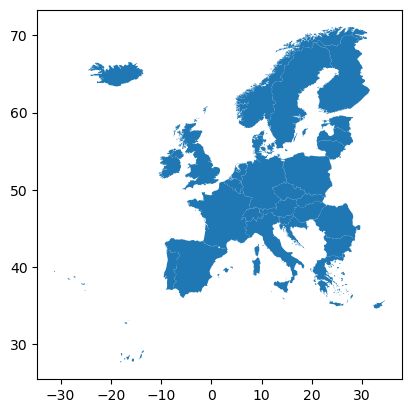

In [9]:
eu_borders.plot()

# Exploring forest cover data 
TODO

# Plotting forest fraction data

### Forest fraction
Dimension:   
- Time: 2020  
- Latitude  
- Longitude 
  
Variable:  
- Forest_cover_fraction  
  
Spatial resolution: 100m  

In [10]:
# Directory to the NetCDR file
forest_fraction = Path(f"{input_dir}/Forest4model_v1_Forest_cover_fraction.nc")

# Read the data
ds = xr.open_dataset(forest_fraction)["Forest_cover_fraction"].isel(time=0)

In [11]:
ds

<xarray.DataArray 'Forest_cover_fraction' (latitude: 37778, longitude: 101055)>
[3817655790 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 72.66 72.66 72.66 72.66 ... 24.29 24.29 24.29
  * longitude  (longitude) float64 -56.5 -56.5 -56.5 -56.5 ... 72.9 72.9 72.91
    time       datetime64[ns] 2020-01-01
Attributes:
    grid_mapping:  crs
    long_name:     Forest cover fraction
    references:    https://worldcover2020.esa.int/; https://glad.umd.edu/data...
    units:         adimensional
    valid_max:     1000
    valid_min:     0

In [12]:
# Reprojection to the CRS in subregion borders
ds_reproject = ds.rio.write_crs(eu_borders.crs)

In [13]:
ds_reproject.rio.crs

CRS.from_epsg(4326)

# Forest areas in DEU and FRA - Testing

### Grids with forest / forest occurrence
Calculate percentage of forest area over land mass (i.e. grids with the forest)
1. Get area for de_border -> land mass in million ha
2. Check grid resolution
3. Count numbers of grid with values > 0
4. Multiply total numbers of grid where values > 0 by grid resolution. Convert to million ha -> this is total forest area
5. Ratio total forest area / total land mass 

### Forest area in each grid
Calculate percentage of area covered by forest in each grid (total forest area based on the probability)
1. Multiply each fraction in the grid with grid resolution -> get forest area/probability per grid
2. Sum the forest area per grid to get total forest area (based on probability)
3. Ratio total forest area in probability / total land mass 

CPU times: user 8.41 s, sys: 2.07 s, total: 10.5 s
Wall time: 10.6 s


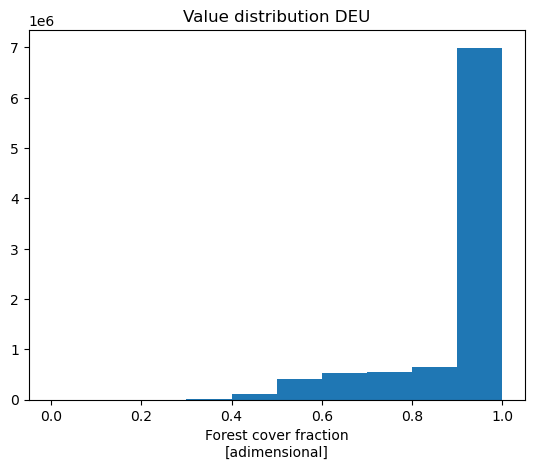

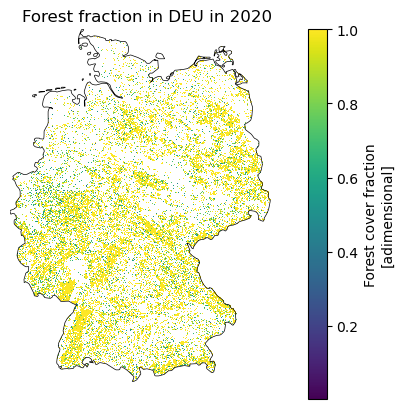

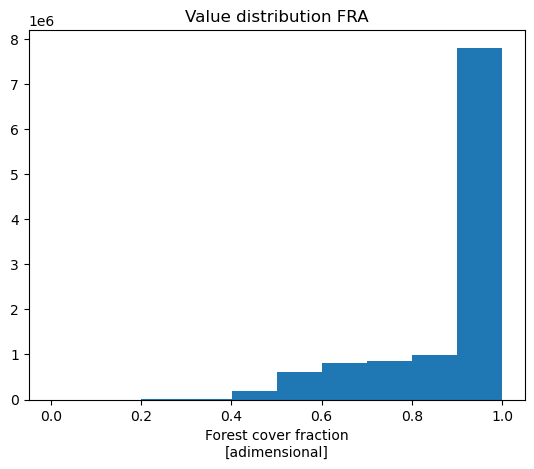

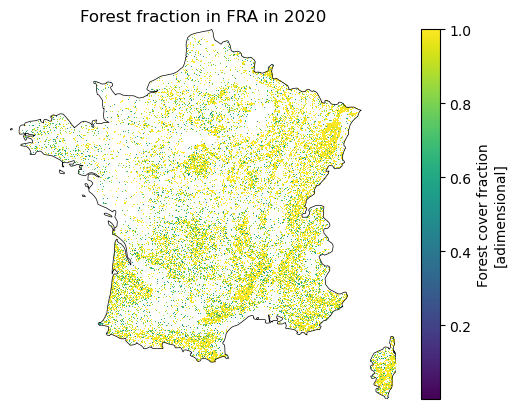

In [16]:
%%time

eu_list = ["DEU", "FRA"]
perc_forest_occurrence = []
perc_forest_area = []
grid_with_forest = []
forest_area = []
land_mass = []
iso_forest_fraction = {}

for iso in eu_list:

    # Clipping EU map
    border = subregion_borders.loc[[iso]]
    iso_forest_fraction[iso] = ds_reproject.rio.clip_box(
        *border.total_bounds
    ).rio.clip(border.geometry, crs=ds_reproject.rio.crs)

    ### PROBABILITY DISTRIBUTION ###
    figure, ax_1 = plt.subplots()
    iso_forest_fraction[iso].plot.hist(ax=ax_1)
    ax_1.set(title=f"Value distribution {iso}")

    plt.savefig(output_figure_dir/f"{iso}_forest_fraction_hist")

    ### MAP ###
    # Figure template
    figure, ax = plt.subplots()

    # Plot the forest fraction
    non_zero = iso_forest_fraction[iso].where(iso_forest_fraction[iso] > 0)
    non_zero.plot.imshow(cmap='viridis', ax=ax)

    # Plot administration border
    border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    # Additional information
    ax.axis("off")
    ax.set(title=f"Forest fraction in {iso} in 2020")

    # Save figure
    plt.savefig(output_figure_dir/f"{iso}_forest_fraction_map.png", dpi=300)

    ### GRIDS WITH FOREST ### 
    forest_grid_sum = non_zero.count(["latitude", "longitude"]).values.flatten()[0]
    forest_grids = forest_grid_sum / 1e+6
    grid_with_forest.append(forest_grids)

    country_land_mass = border["AREA"].values[0] / 1e+3 # in million hectares 
    land_mass.append(country_land_mass)

    country_perc_forest = (forest_grids / country_land_mass) * 100
    perc_forest_occurrence.append(country_perc_forest)

    ### FOREST AREA ###
    calc_forest_area = iso_forest_fraction[iso].sum(["latitude", "longitude"]).values.flatten()[0]
    country_forest_area = calc_forest_area / 1e+6 # in million ha
    forest_area.append(country_forest_area)

    perc_forest_ha = (country_forest_area / country_land_mass) * 100
    perc_forest_area.append(perc_forest_ha)

    iso_forest_fraction[iso].close()

# Save data in a dataframe
forest_fraction_df = pd.DataFrame(
    {
        "iso" : eu_list,
        "land_area_FAO_2002 (mha)" : land_mass,
        "forest_occurrence (mha)" : grid_with_forest,
        "percentage_forest_occurrence (%)" : perc_forest_occurrence,
        "forest_area (mha)" : forest_area,
        "percentage_forest_area (%)" : perc_forest_area
    }
)

In [17]:
forest_fraction_df

,iso,land_area_FAO_2002 (mha),forest_occurrence (mha),percentage_forest_occurrence (%),forest_area (mha),percentage_forest_area (%)
0,DEU,34.895,9.251619,26.512735,8.537263,24.465577
1,FRA,55.010,11.288331,20.520507,10.190472,18.524763


# Plotting forest cover data

- No CRS yet
- Spatial extent (lon_max, lat_max, lon_min, lat_min): (72.9, 72.66, -56.50, 24.28)
- Year = 2020
- Descriptive stats:
  - Minimum: 1
  - Maximum: 1??
  - Average: 0.99
  - Median: 

In [24]:
# Directory to the NetCDR file
forest_cover = Path(f"{input_dir}/Forest4model_v1_Forest_cover.nc")

# Read the data
ds_cover = xr.open_dataset(forest_cover)

In [26]:
# Reprojection to the CRS in subregion borders
ds_cover_reproject = ds_cover.rio.write_crs(eu_borders.crs)

In [27]:
ds_cover_reproject.rio.crs

CRS.from_epsg(4326)

## Forest cover in DEU

[Text(0.5, 1.0, 'Forest fraction in DEU in 2020')]

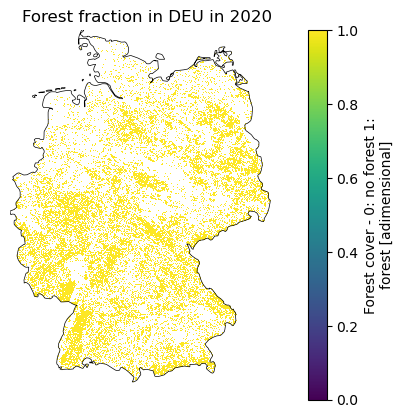

In [28]:
# Clipping EU map
border = subregion_borders.loc[["DEU"]]
country_forest = ds_cover_reproject.rio.clip_box(
    *border.total_bounds
).rio.clip(border.geometry, crs=ds_cover_reproject.rio.crs)

### PLOTTING ###
# Figure template
figure, ax = plt.subplots()

# Colormap
cmap = plt.cm.viridis

# Colormap normalization instance
norm = mcolors.Normalize(vmin=0, vmax=1)

# Plot the forest fraction
forest_data = country_forest["Forest_cover"].isel(time=0) 
forest_clean = forest_data.where(forest_data <= 1)
forest_clean.plot.imshow(ax=ax, cmap=cmap, norm=norm)

# Plot administration border
border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

# Additional information
ax.axis("off")
ax.set(title=f"Forest fraction in DEU in 2020")

In [29]:
# Check areas for forest cover
forest_data = country_forest["Forest_cover"].isel(time=0) 
forest_clean = forest_data.where((forest_data <= 1) & (forest_data > 0))

In [30]:
forest_cov_count = forest_clean.count(["latitude", "longitude"]).values.flatten()[0]

country_land_mass = border["AREA"].values[0] * 1000 # in hectares

de_perc_forest = (forest_cov_count / country_land_mass) * 100

In [31]:
forest_cov_count

9251345

In [32]:
de_perc_forest

# Result is the same as if I calculate forest occurrence using forest fraction data

26.511950136122653

# Exploring forest gain, loss, and stable

In [16]:
# Clipping EU map
def clip_array(xarray_input, iso_code, shp_border):

    # Reprojection to the CRS in subregion borders
    ds_reproject = xarray_input.rio.write_crs(shp_border.crs)

    border = shp_border.loc[[iso_code]]
    country_forest = ds_reproject.rio.clip_box(
        *border.total_bounds
    ).rio.clip(border.geometry, crs=ds_reproject.rio.crs)

    return country_forest

In [19]:
%%time

file  = ["loss", "gain", "stable"]
all_data = {}

for iso in ["DEU", "FRA"]:
    iso_data = {}

    for f in file:
        # Directory to the NetCDR file
        data_dir = Path(f"{input_dir}/Forest4model_v1_Forest_extent_{f}.nc")

        # Read the data
        ds = xr.open_dataset(data_dir)[f"Forest_extent_{f}"].isel(time=0)

        # Clipping to country border
        iso_data[f] = clip_array(ds, iso, eu_borders)

    iso_combined = xr.merge([iso_data["loss"], iso_data["gain"], iso_data["stable"]])

    # Re-code the values according to the specified rules
    iso_combined = xr.where(iso_combined == iso_data["loss"], -1, iso_combined)
    iso_combined = xr.where(iso_combined == iso_data["gain"], 1, iso_combined)
    iso_combined = xr.where(iso_combined == iso_data["stable"], 0, iso_combined)

    # Add attributes to the combined_data
    iso_combined.attrs.update({
        'country' : iso,
        'description': 'Combined forest loss, gain, and stable data with re-coded values',
        're-coding': 'Values == +1 for forest gain, -1 for forest loss, and 0 for forest stable'
    })

    all_data[iso] = iso_combined

CPU times: user 7.62 s, sys: 4.47 s, total: 12.1 s
Wall time: 3min 23s


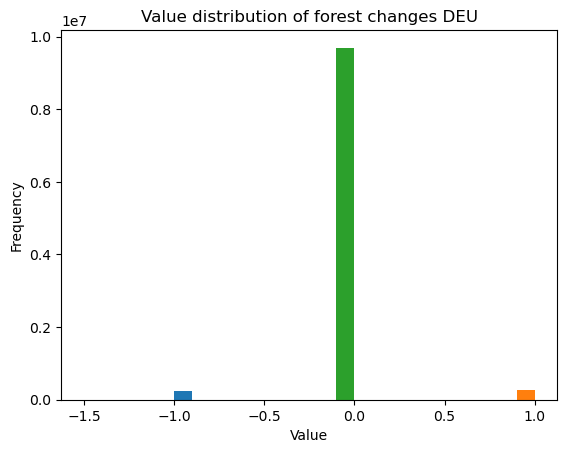

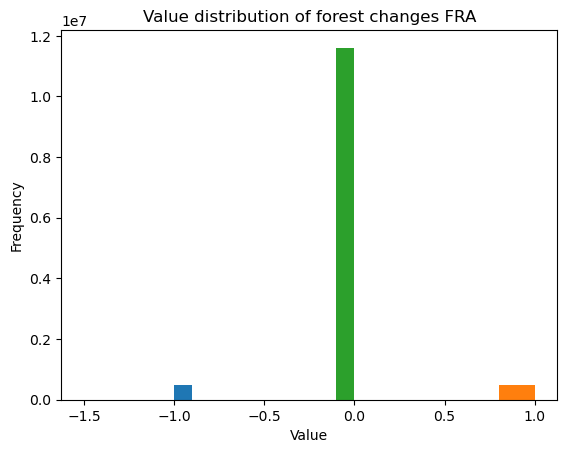

In [20]:
for iso in all_data.keys():
    fig, ax = plt.subplots()
    for var in all_data[iso].data_vars:
        all_data[iso][var].plot.hist(ax=ax)
        ax.set(
            title = f"Value distribution of forest changes {iso}", 
            xlabel = "Value",
            ylabel = "Frequency"
        )

In [54]:
forest_change = {}

for iso in all_data.keys():
    var_data = {}

    for var in all_data[iso].data_vars:
        var_data[var] = (
            all_data[iso][var]
            .count(["latitude", "longitude"])
            .values
            .flatten()[0]
        ) / 1e+6 # to million ha
    
    forest_change[iso] = var_data



In [55]:
forest_change["DEU"]

{'Forest_extent_loss': 0.234726,
 'Forest_extent_gain': 0.262124,
 'Forest_extent_stable': 9.694872}

In [56]:
forest_change["FRA"]

{'Forest_extent_loss': 0.479324,
 'Forest_extent_gain': 0.469425,
 'Forest_extent_stable': 11.606737}

CPU times: user 8.96 s, sys: 2.52 s, total: 11.5 s
Wall time: 11.5 s


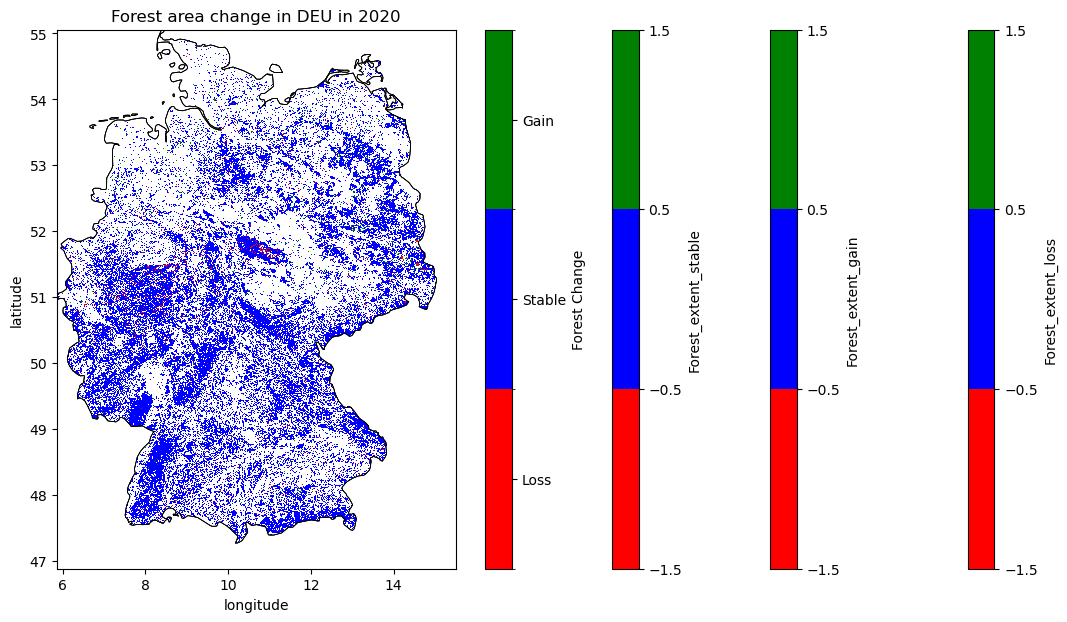

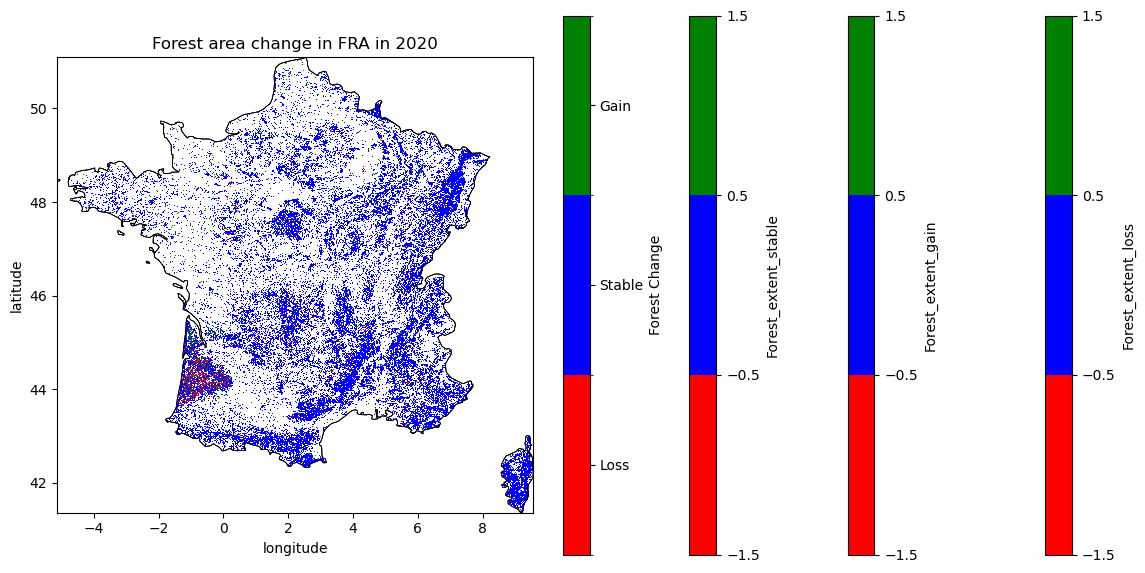

In [36]:
%%time

# Create a custom discrete colormap
cmap = mcolors.ListedColormap(['red', 'blue', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]  # Define the boundaries for the colormap
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for iso in all_data.keys():

    # Figure template
    figure, ax = plt.subplots(figsize=(15,7))

    for var in all_data[iso].data_vars:
        data = all_data[iso][var]

        # Plot the data without a label
        data.plot.imshow(cmap=cmap, ax=ax, label=None, norm=norm)

        # Plot administration border
        border = eu_borders.loc[[iso]]
        border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    # Add a color bar
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, ticks=[-1, 0, 1])
    cbar.set_ticklabels(['Loss', 'Stable', 'Gain'])
    cbar.set_label('Forest Change')

    ax.set_title(f'Forest area change in {iso} in 2020')

# Exploring aboveground biomass
- Only depict aboveground biomass for forest area 
- The processing to create this dataset include taking aboveground biomass from Santoro and Cartus (2023) which is then masked with forest cover 2020 mask
- So it is sure that this data covers aboveground biomass in forest area

In [57]:
# Directory to the NetCDF file
forest_agb_dir = Path(f"{input_dir}/Forest4model_v1_Forest_agb.nc")

# Read the data
ds_agb = xr.open_dataset(forest_agb_dir)["Forest_agb"].isel(time=0)

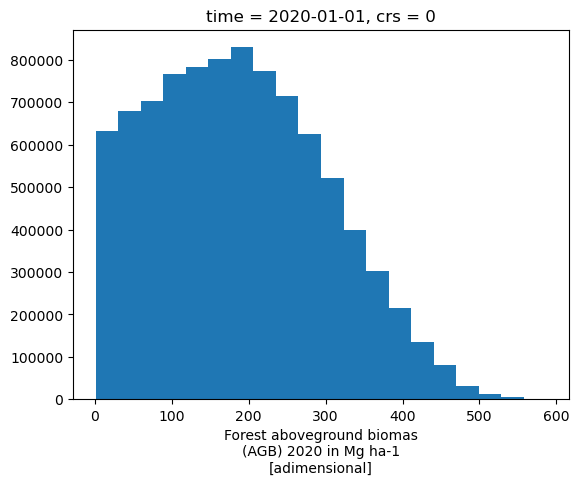

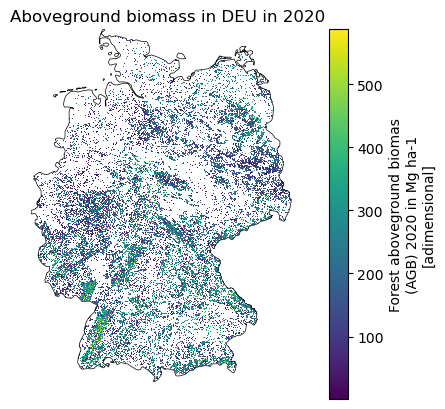

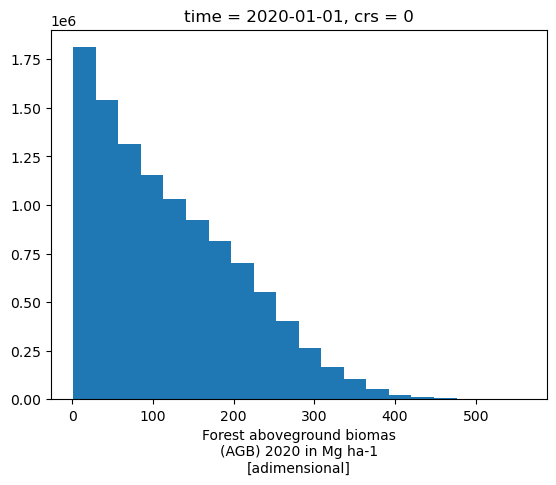

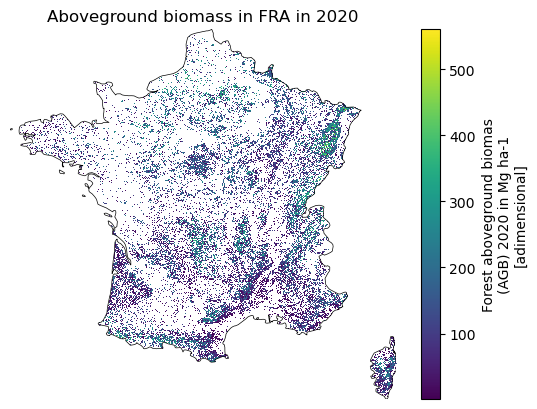

In [58]:
iso_list = ["DEU", "FRA"]
total_agb_mg = []

for iso in iso_list:
    # Clip the array
    iso_agb = clip_array(ds_agb, iso, eu_borders)

    # Plotting data distribution
    figure, ax_1 = plt.subplots()
    
    # Select data where values > 0
    iso_agb_nonzero = iso_agb.where(iso_agb > 0)
    iso_agb_nonzero.plot.hist(bins=20, ax=ax_1)

    # # Save figure
    # plt.savefig(output_figure_dir/f"{iso}_forest_agb_hist.png")

    # Mapping
    figure, ax = plt.subplots()

    # Plot the forest fraction
    iso_agb_nonzero.plot.imshow(cmap='viridis', ax=ax)

    # Plot administration border
    border = eu_borders.loc[[iso]]
    border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    # Additional information
    ax.axis("off")
    ax.set(title=f"Aboveground biomass in {iso} in 2020")

    # # Save figure
    # plt.savefig(output_figure_dir/f"{iso}_forest_agb_map.png")

    ### CALCULATING TOTAL FOREST BIOMASS ###
    iso_total_agb = iso_agb * iso_forest_fraction[iso]

    iso_total_nonzero = iso_total_agb.where(iso_total_agb > 0)

    total_agb_mg.append(
        iso_total_nonzero
        .sum(["latitude", "longitude"])
        .values
        .flatten()[0]
    )

# Save data in a dataframe
agb_data = pd.DataFrame(
    {
        "iso" : iso_list,
        "total_agb_mg" : total_agb_mg
    }
)

In [59]:
agb_data

,iso,total_agb_mg
0,DEU,1.585299e+09
1,FRA,1.187453e+09


In [ ]:
agb_data["total_agb_mg"] / 1e+6

# Explore tree canopy data
- Contains canopy height data
- Can be combined with forest fraction data to map forest area following the definition in each country i.e. instead of categorising forest fraction > 10% and tree canopy height > 5m as forest, we can follow forest definition in Germany
- Combining with forest age, forest height, and aboveground biomass, we can: 
  - Calculate total (biomass) carbon storage in a country or carbon storage/ha 
  - Calculate carbon storage/ha in each tree age and tree height classes
  - Using forest age classes, we can determine the rate of sequestration for different age classes -> providing information for A/R projects in the respective country
  - Combination of tree height and disturbance data can provide information which height classes are prone to disturbance risk. Including forest age data can provide additional information on the combo of height x age classes that are prone to disturbance risk

In [40]:
# Directory to the NetCDR file
canopy_dir = Path(f"{input_dir}/Forest4model_v1_Canopy_height.nc")

# Read the data
ds_canopy = xr.open_dataset(canopy_dir)["Canopy_height"].isel(time=0)

In [41]:
ds_canopy

<xarray.DataArray 'Canopy_height' (latitude: 37778, longitude: 101055)>
[3817655790 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 72.66 72.66 72.66 72.66 ... 24.29 24.29 24.29
  * longitude  (longitude) float64 -56.5 -56.5 -56.5 -56.5 ... 72.9 72.9 72.91
    time       datetime64[ns] 2020-01-01
Attributes:
    grid_mapping:  crs
    long_name:     Tree canopy height 2020
    references:    https://glad.umd.edu/dataset/GLCLUC2020
    units:         adimensional
    valid_max:     50
    valid_min:     1

In [42]:
deu_canopy = clip_array(ds_canopy, "DEU", eu_borders)

(array([2.600000e+01, 7.827000e+03, 3.144200e+04, 2.448350e+05,
        1.270280e+05, 2.511990e+05, 1.353660e+05, 3.208600e+05,
        1.968430e+05, 4.957980e+05, 7.025040e+05, 4.843980e+05,
        1.726185e+06, 1.074900e+06, 1.590353e+06, 7.639590e+05,
        9.398860e+05, 1.086670e+05, 2.712300e+04, 8.670000e+02]),
 array([ 1.        ,  2.54999995,  4.0999999 ,  5.6500001 ,  7.19999981,
         8.75      , 10.30000019, 11.85000038, 13.39999962, 14.94999981,
        16.5       , 18.04999924, 19.60000038, 21.14999962, 22.70000076,
        24.25      , 25.79999924, 27.35000038, 28.89999962, 30.45000076,
        32.        ]),
 <BarContainer object of 20 artists>)

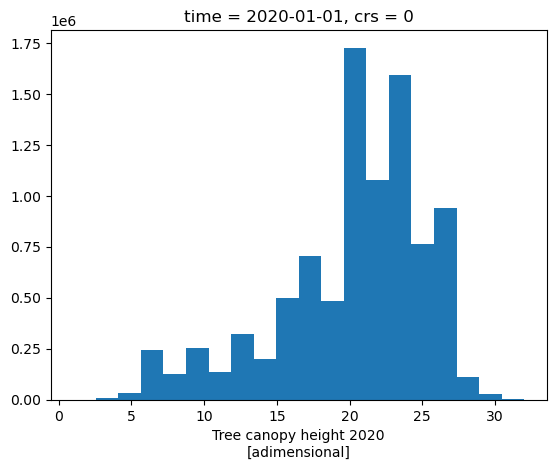

In [43]:
# Height is between 1 to 50 meters
deu_canopy.plot.hist(bins=20)

[Text(0.5, 1.0, 'Canopy height in DEU in 2020')]

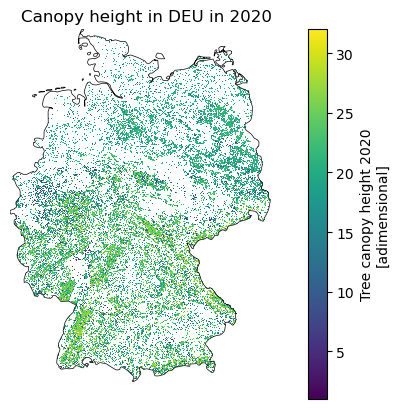

In [44]:
# Mapping
figure, ax = plt.subplots()

# Plot the forest fraction
deu_canopy.plot.imshow(cmap='viridis', ax=ax)

# Plot administration border
border = eu_borders.loc[["DEU"]]
border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

# Additional information
ax.axis("off")
ax.set(title="Canopy height in DEU in 2020")

# Exploring forest fragment data
Forest fragmentation in 2020:
- Downscaling global fragmentation data in 2020 (Ma et al) from 4km to 100m resolution
- Masking the downscaled fragmentation with forest cover in 2020 to identify fragmentation in forest area

Thinking:
- Combining it with natural forest data, we can identify the fragmentation in natural forest area
- Combining it with forest type data, we can identify which tree species (i.e. broadleaves, conifers, etc) affected by fragmentation
- Data description in D2.1 document says that the data has floating values from 0 to 1 (possibly showing the percentage of fragmentation in a grid), but why does the data I import show value from 0.37 - 28.00?
  - 28 is a no_data value

In [17]:
fragment_dir = Path(f"{input_dir}/Forest4model_v1_Forest_fragment.nc")

# Read the data
ds_fragment = xr.open_dataset(fragment_dir)["Forest_fragment"].isel(time=0)

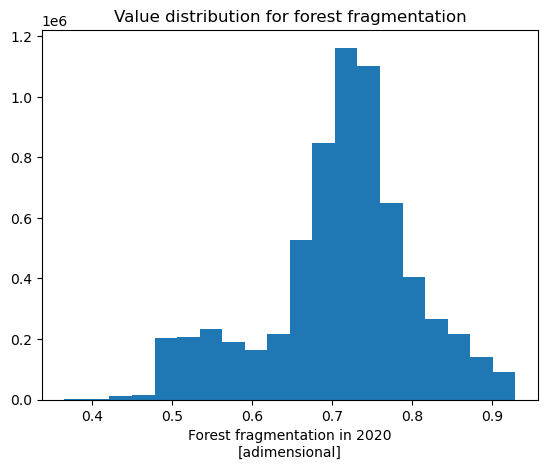

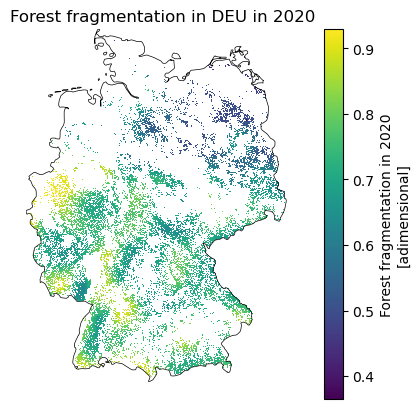

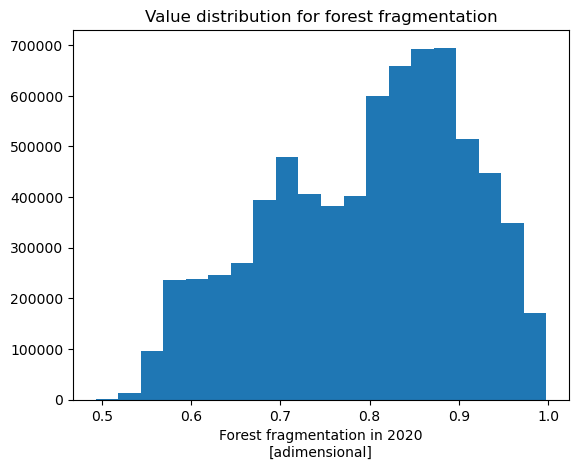

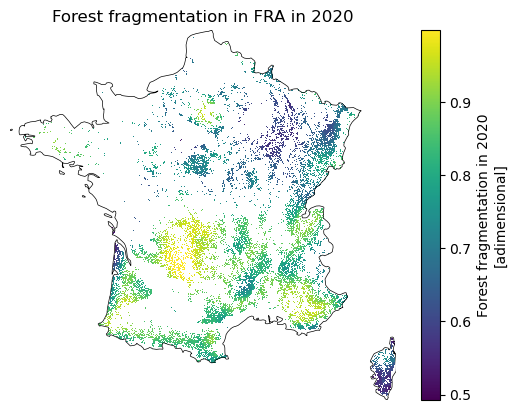

In [27]:
iso_list = ["DEU", "FRA"]
calc_area = []


for iso in iso_list:

    # Clipping EU forest map
    iso_fragment = clip_array(ds_fragment, iso, eu_borders)

    # Removing no_data value, which is 28
    iso_fragment_clean = iso_fragment.where(iso_fragment < 28)

    # Plotting value distribution
    figure, ax_1 = plt.subplots()
    iso_fragment_clean.plot.hist(bins=20, ax=ax_1)
    ax_1.set_title("Value distribution for forest fragmentation")

    # Plotting forest fragmentation
    figure, ax = plt.subplots()
    iso_fragment_clean.plot.imshow()

    # Plot administration border
    border = eu_borders.loc[[iso]]
    border.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    # Additional information
    ax.axis("off")
    ax.set(title=f"Forest fragmentation in {iso} in 2020")

    # Calculate fragmentation area in million ha
    fragment_area = iso_fragment_clean.sum(["latitude", "longitude"]).values.flatten()[0] / 1e+6
    calc_area.append(fragment_area)

fragment_forest = pd.DataFrame(
    {
        "iso" : iso_list,
        "Fragmentation in forest (mha)" : calc_area
    }
)

In [28]:
fragment_forest

,iso,Fragmentation in forest (mha)
0,DEU,4.724438
1,FRA,5.813986


### Recent land area data from World Bank

In [47]:
# land_area_external = pd.read_excel(f"{input_dir}/API_AG.LND.TOTL.K2_DS2_en_excel_v2_1051.xls", sheet_name="Data", skiprows=3)

In [48]:
# land_area_external = land_area_external[["Country Code", "2021"]]

In [49]:
# land_area_external.rename(
#     columns={
#         "Country Code" : "iso",
#         "2021" : "land_area_World_Bank_2021 (km2)"
#     }, inplace=True
# )

In [50]:
# land_area_external["land_area_World_Bank_2021 (ha)"] = land_area_external["land_area_World_Bank_2021 (km2)"] * 100

In [52]:
# land_area_external = land_area_external[["iso", "land_area_World_Bank_2021 (ha)"]]

In [53]:
# merged_df = pd.merge(forest_data, land_area_external, on="iso")

In [54]:
# merged_df